# Module 5 - Modern Portfolio Theory

In this module, We’ll be looking at investment portfolio optimization with python, the
fundamental concept of diversification and the creation of an efficient frontier that can be used by investors to choose
specific mixes of assets based on investment goals; that is, the trade off between their desired level of portfolio
return vs their desired level of portfolio risk.

[Modern Portfolio Theory](https://www.investopedia.com/terms/m/modernportfoliotheory.asp) suggests that it is possible to 
construct an "efficient frontier" of optimal portfolios,
offering the maximum possible expected return for a given level of risk. It suggests that it is not enough to look at
the expected risk and return of one particular stock. By investing in more than one stock, an investor can reap the
benefits of diversification, particularly a reduction in the riskiness of the portfolio. MPT quantifies the benefits of
diversification, also known as not putting all of your eggs in one basket.

In [1]:
import pandas as pd
import numpy as np
from pandas import Series, DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import os
import re
import glob
import random

## Problem Statements

## 5.1 
For your chosen stock, calculate the mean daily return and daily standard deviation of returns, and then just annualise them to get mean expected annual return and volatility of that single stock. ( annual mean = daily mean * 252 , annual stdev = daily stdev * sqrt(252) )

In [2]:
def read_csv( filename ):
    if isinstance(filename, pd.DataFrame): return filename  # OPTIMIZATION: allow passthrough of existing dataframe
    
    dataframe = pd.read_csv( filename, parse_dates=['Date'] )
    dataframe.set_index( dataframe.Date, inplace=True )
    return dataframe

def meanDailyReturn( filename ):
    return read_csv( filename ).Close_Price.pct_change().dropna().mean()

def meanDailySTD( filename ):
    return read_csv( filename ).Close_Price.pct_change().dropna().std()

def meanAnnualReturn( filename ):
    return meanDailyReturn(filename) * 252

def meanAnnualSTD( filename ):
    return meanDailySTD(filename) * np.sqrt(252)

def getName( filename ):
    return re.sub(r'^.+/|\.[^.]+$',     '',    filename)

def getCap( filename ):
    return re.sub(r'^.*/(\w+_Cap)/.*$', '\\1', filename)

def calcReturnVolatility( filename ):
    input  = read_csv( filename )
    output = DataFrame([{
        "Name":             getName( filename ),
        "Cap":              getCap(  filename ),
        "meanDailyReturn":  meanDailyReturn( input ),
        "meanDailySTD":     meanDailySTD( input ),
        "meanAnnualReturn": meanAnnualReturn( input ),
        "meanAnnualSTD":    meanAnnualSTD( input )
    }])
    output.set_index( output.Name, inplace=True, drop=False )
    return output

stock = '../../data_output/module_1/python3/stocks/Large_Cap/ADANIPORTS.csv'
calcReturnVolatility(stock)

,Cap,Name,meanAnnualReturn,meanAnnualSTD,meanDailyReturn,meanDailySTD
Name,,,,,,
ADANIPORTS,Large_Cap,ADANIPORTS,0.060499,0.309751,0.00024,0.019512


## 5.2 
Now, we need to diversify our portfolio. Build your own portfolio by choosing any 5 stocks, preferably of different sectors and different caps. Assume that all 5 have the same weightage, i.e. 20% . Now calculate the annual returns and volatility of the entire portfolio ( Hint : Don't forget to use the covariance )

In [3]:
filenames_all = glob.glob('../../data_output/module_1/python3/stocks/**/*.csv')
filenames     = random.sample( filenames_all, 5 )

summary_all   = pd.concat([ calcReturnVolatility(stock) for stock in filenames_all ])
summary       = pd.concat([ calcReturnVolatility(stock) for stock in filenames     ])
summary

,Cap,Name,meanAnnualReturn,meanAnnualSTD,meanDailyReturn,meanDailySTD
Name,,,,,,
DRREDDY,Large_Cap,DRREDDY,0.068044,0.298319,0.000270,0.018792
BAJFINANCE,Large_Cap,BAJFINANCE,0.454332,0.321058,0.001803,0.020225
NBCC,Mid_Cap,NBCC,-0.515176,0.508672,-0.002044,0.032043
APOLLOTYRE,Mid_Cap,APOLLOTYRE,-0.064303,0.310445,-0.000255,0.019556
VOLTAS,Mid_Cap,VOLTAS,0.191030,0.308346,0.000758,0.019424


In [4]:
portfolio = DataFrame()
for filename in filenames:
    portfolio[ getName(filename) ] = read_csv(filename).Close_Price
portfolio.head()

,DRREDDY,BAJFINANCE,NBCC,APOLLOTYRE,VOLTAS
Date,,,,,
2017-05-15,2675.80,1332.95,197.60,231.90,431.85
2017-05-16,2724.10,1347.75,198.25,234.40,432.45
2017-05-17,2736.90,1324.80,200.35,237.35,430.20
2017-05-18,2678.95,1314.55,194.20,232.65,414.10
2017-05-19,2656.45,1289.15,193.55,234.65,415.75


In [5]:
weights = np.full( portfolio.shape[1], 1/portfolio.shape[1] )
weights

array([0.2, 0.2, 0.2, 0.2, 0.2])

In [6]:
# Portfolio Mean Average Return can be calculated either from: the summary data or the portfolio table
portfolio_annual_returns = np.sum( portfolio.pct_change().mean() * weights ) * 252  
portfolio_annual_returns

0.026785455925437757

In [7]:
portfolio_annual_returns = summary.meanAnnualReturn.mean()
portfolio_annual_returns

0.026785455925437775

In [8]:
# NOTE: mean().mean() works because weights between each of the stocks is equal
portfolio_annual_returns = portfolio.pct_change().mean().mean() * 252  
portfolio_annual_returns

0.026785455925437775

In [9]:
# Portfolio Covarence matrix
portfolio_covarence = portfolio.pct_change().cov()
portfolio_covarence

,DRREDDY,BAJFINANCE,NBCC,APOLLOTYRE,VOLTAS
DRREDDY,0.000353,0.000071,0.000080,0.000064,0.000029
BAJFINANCE,0.000071,0.000409,0.000154,0.000135,0.000138
NBCC,0.000080,0.000154,0.001027,0.000144,0.000130
APOLLOTYRE,0.000064,0.000135,0.000144,0.000382,0.000127
VOLTAS,0.000029,0.000138,0.000130,0.000127,0.000377


In [10]:
portfolio_annual_volatility = np.sqrt(
    np.dot( 
        weights.T, 
        np.dot( portfolio.pct_change().cov(), weights )
    ) 
    * np.sqrt(252)
)
round( portfolio_annual_volatility, 2 )

0.05

In [11]:
print("Portfolio Annualized Mean Return: ", round(portfolio_annual_returns,2)    )
print("Portfolio Annualized Volatility:  ", round(portfolio_annual_volatility,2) )

Portfolio Annualized Mean Return:  0.03
Portfolio Annualized Volatility:   0.05


## 5.3 
Prepare a scatter plot for differing weights of the individual stocks in the portfolio , the axes being the returns and volatility. Colour the data points based on the Sharpe Ratio ( Returns/Volatility) of that particular portfolio.

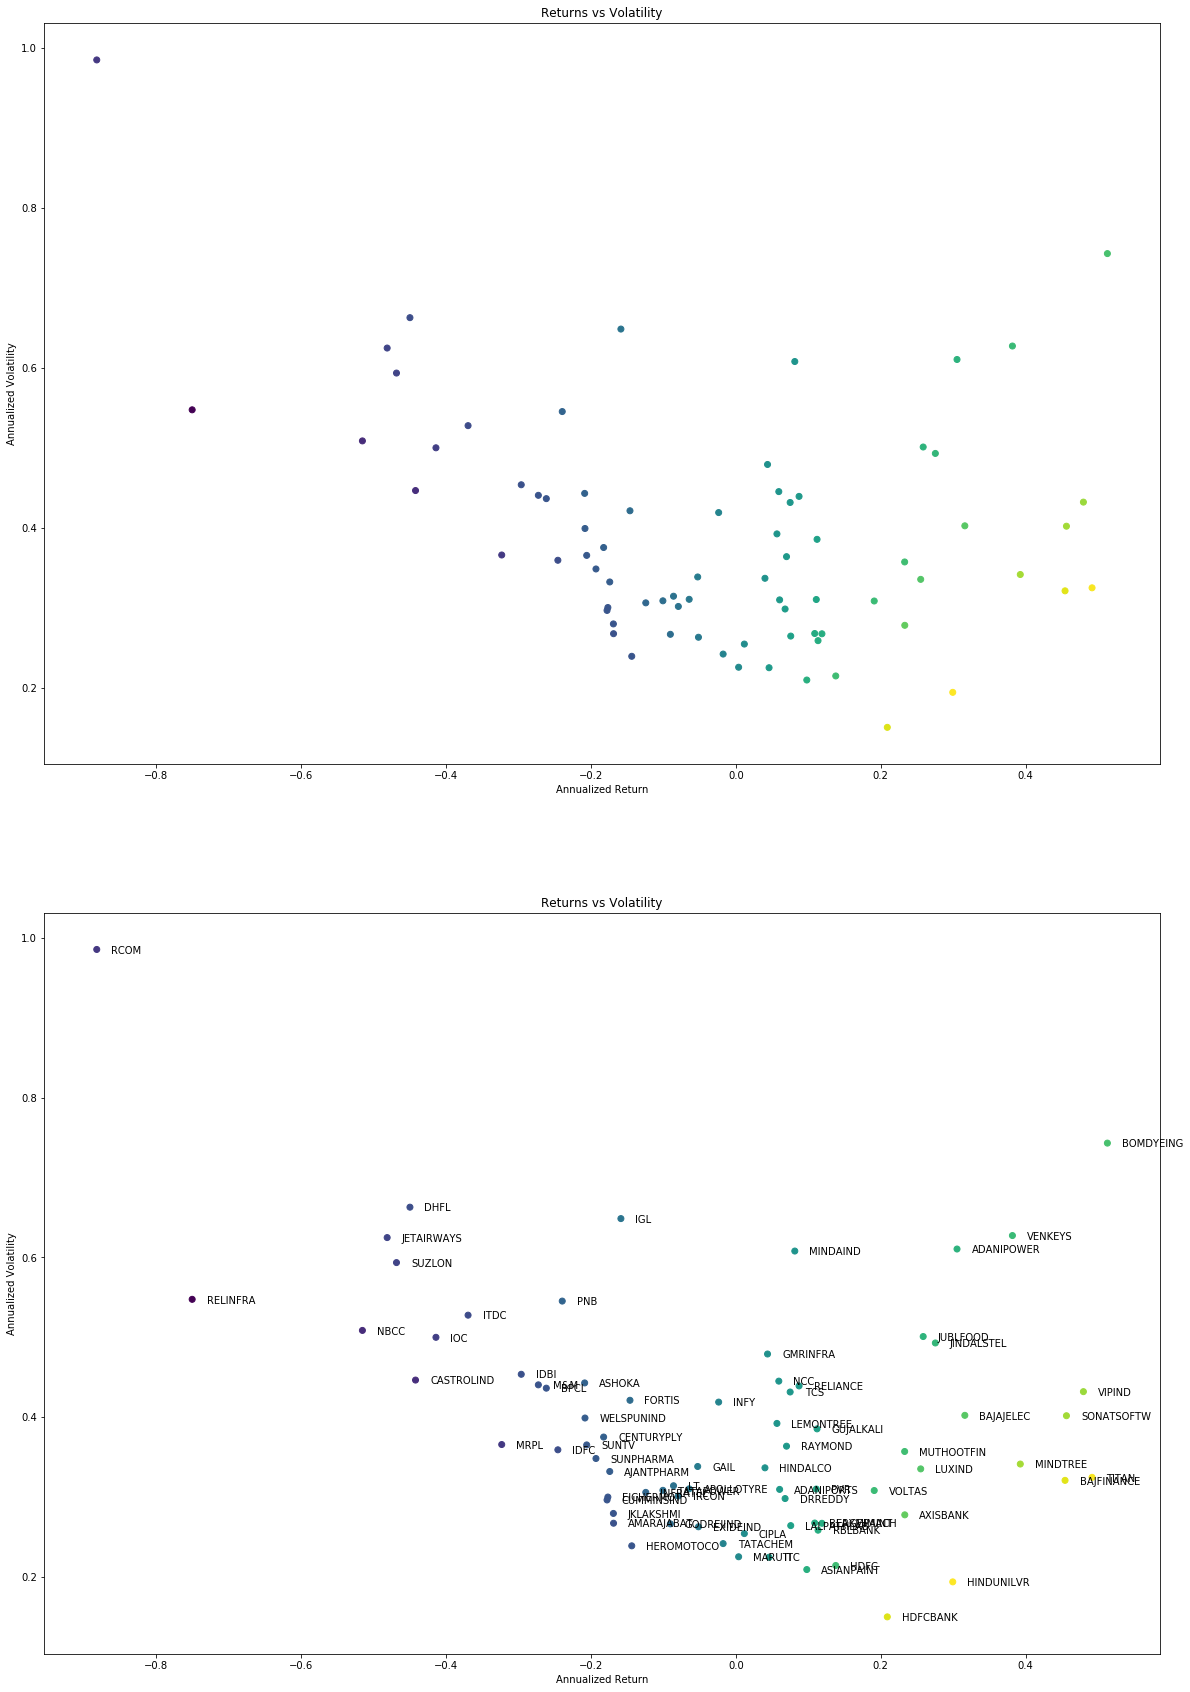

In [12]:
summary_all['Sharpe'] = summary_all.meanAnnualReturn / summary_all.meanAnnualSTD

fig, axes = plt.subplots(figsize=(20, 30), nrows=2, ncols=1)
for n in range(0,2):
    axes[n].scatter( 
        summary_all.meanAnnualReturn, 
        summary_all.meanAnnualSTD, 
        c     = summary_all['Sharpe'],
        label = summary_all['Sharpe']
    )
    axes[n].set_title('Returns vs Volatility')
    axes[n].set_xlabel('Annualized Return')
    axes[n].set_ylabel('Annualized Volatility')

for i in range(0, summary_all.shape[0]):
    axes[n].annotate(summary_all.Name[i], (summary_all.meanAnnualReturn[i]+0.02, summary_all.meanAnnualSTD[i] - 0.005))

# 5.4 Mark the 2 portfolios where:
- Portfolio 1 - The Sharpe ratio is the highest 
- Portfolio 2 - The volatility is the lowest.

In [13]:
portfolio_1 = summary_all.sort_values('Sharpe',ascending=False).head(5)
portfolio_1

,Cap,Name,meanAnnualReturn,meanAnnualSTD,meanDailyReturn,meanDailySTD,Sharpe
Name,,,,,,,
HINDUNILVR,Large_Cap,HINDUNILVR,0.299378,0.194041,0.001188,0.012223,1.542859
TITAN,Large_Cap,TITAN,0.491593,0.324836,0.001951,0.020463,1.513358
BAJFINANCE,Large_Cap,BAJFINANCE,0.454332,0.321058,0.001803,0.020225,1.415107
HDFCBANK,Large_Cap,HDFCBANK,0.209085,0.150248,0.000830,0.009465,1.391600
MINDTREE,Mid_Cap,MINDTREE,0.392570,0.341485,0.001558,0.021512,1.149595


In [14]:
portfolio_2 = summary_all.sort_values('meanAnnualSTD',ascending=True).head(5)
portfolio_2

,Cap,Name,meanAnnualReturn,meanAnnualSTD,meanDailyReturn,meanDailySTD,Sharpe
Name,,,,,,,
HDFCBANK,Large_Cap,HDFCBANK,0.209085,0.150248,0.000830,0.009465,1.391600
HINDUNILVR,Large_Cap,HINDUNILVR,0.299378,0.194041,0.001188,0.012223,1.542859
ASIANPAINT,Large_Cap,ASIANPAINT,0.097990,0.209462,0.000389,0.013195,0.467816
HDFC,Large_Cap,HDFC,0.137945,0.214557,0.000547,0.013516,0.642930
ITC,Large_Cap,ITC,0.045928,0.224856,0.000182,0.014165,0.204255
